### Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

%matplotlib inline

In [2]:
classification_data, classification_labels = datasets.make_classification(
    n_samples=100, n_features = 2, n_informative = 2, n_classes = 2, 
    n_redundant=0, n_clusters_per_class=1, random_state=42
)

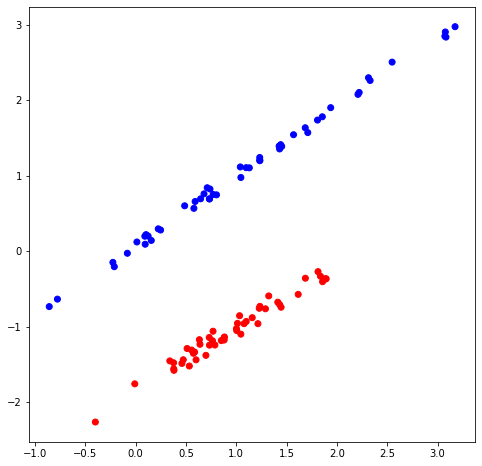

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(
    list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
    c=classification_labels, cmap=colors
)
plt.show()

In [4]:
random.seed(42)

In [5]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [6]:
def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [7]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  
        self.t = t 
        self.true_branch = true_branch  
        self.false_branch = false_branch

In [8]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = {}  
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
          
        prediction = max(classes, key=classes.get)
        return prediction

In [9]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
def quality(left_labels, right_labels, current_gini):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [11]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [12]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [13]:
def find_best_split(data, labels):
    
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [14]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

In [15]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [16]:
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [18]:
def tree_vote(forest, data):

    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    predictions_per_object = list(zip(*predictions))
    
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [19]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [21]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels, test_size = 0.3, random_state = 1
)

In [22]:
for n_tree in [1, 3, 10, 50]:
    locals()['my_forest_{0}'.format(n_tree)] = random_forest(train_data, train_labels, n_tree)
    locals()['train_answers_{0}'.format(n_tree)] = tree_vote(locals()['my_forest_{0}'.format(n_tree)], train_data)
    locals()['test_answers_{0}'.format(n_tree)] = tree_vote(
        locals()['my_forest_{0}'.format(n_tree)], test_data
    )
    locals()['train_accuracy_{0}'.format(n_tree)] = round(
        accuracy_metric(train_labels, locals()['train_answers_{0}'.format(n_tree)]), 3
    )
    print('Точность случайного леса из {0} деревьев на обучающей выборке: '.format(n_tree) + 
          str(locals()['train_accuracy_{0}'.format(n_tree)]))
    locals()['test_accuracy_{0}'.format(n_tree)] = round(
        accuracy_metric(test_labels, locals()['test_answers_{0}'.format(n_tree)]), 3
    )
    print('Точность случайного леса из {0} деревьев на тестовой выборке: '.format(n_tree) + 
          str(locals()['test_accuracy_{0}'.format(n_tree)]))

Точность случайного леса из 1 деревьев на обучающей выборке: 97.143
Точность случайного леса из 1 деревьев на тестовой выборке: 96.667
Точность случайного леса из 3 деревьев на обучающей выборке: 98.571
Точность случайного леса из 3 деревьев на тестовой выборке: 96.667
Точность случайного леса из 10 деревьев на обучающей выборке: 97.143
Точность случайного леса из 10 деревьев на тестовой выборке: 96.667
Точность случайного леса из 50 деревьев на обучающей выборке: 98.571
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667


In [23]:
xx, yy = get_meshgrid(train_data)

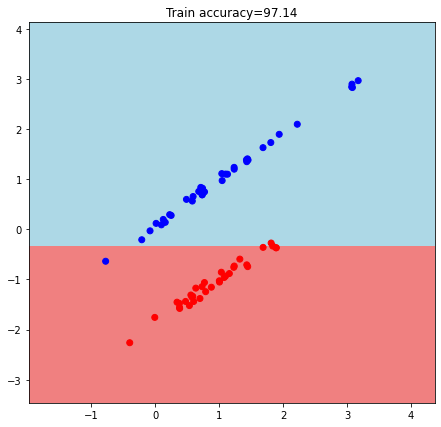

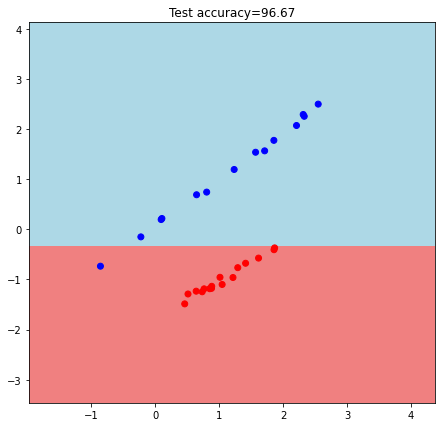

In [30]:
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_1:.2f}')

plt.figure(figsize = (16, 7))
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_1:.2f}')
plt.show()

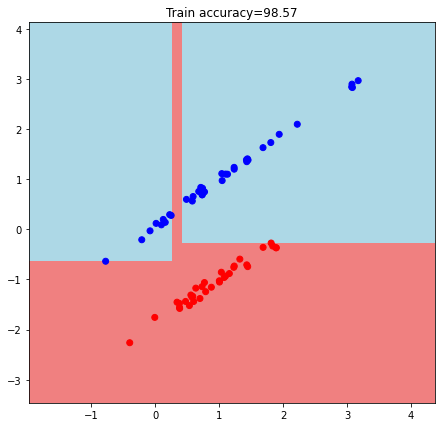

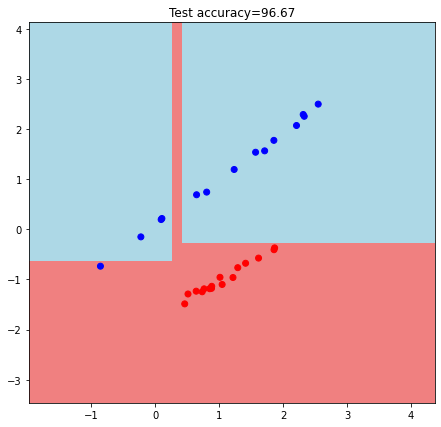

In [31]:
mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_3:.2f}')

plt.figure(figsize = (16, 7))
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_3:.2f}')
plt.show()

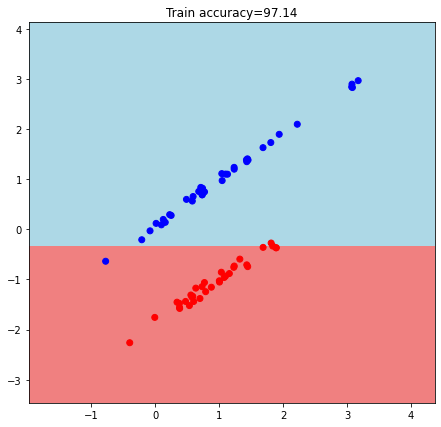

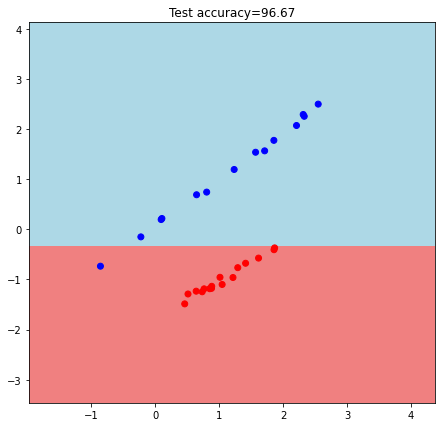

In [32]:
mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_10:.2f}')

plt.figure(figsize = (16, 7))
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_10:.2f}')
plt.show()

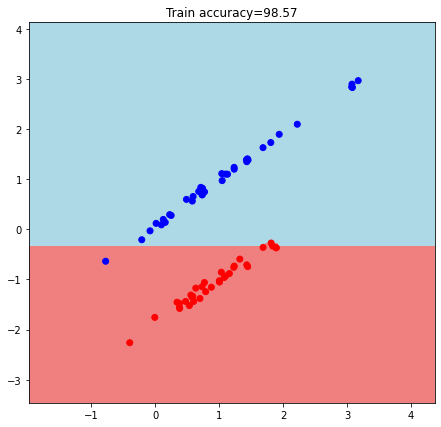

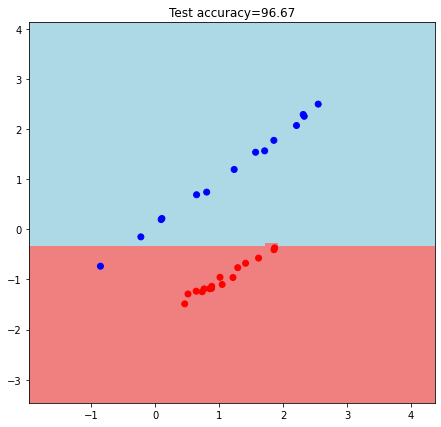

In [33]:
mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_50:.2f}')

plt.figure(figsize = (16, 7))
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_50:.2f}')
plt.show()

#### Лес из 50 деревьев выглядит наиболее простым и наименее переобученным

### Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [34]:
def oob(data, tree):
    oob = []
    
    for item in data:
        if item not in tree:
            oob.append(item)
        
    return oob

In [35]:
def oob_score(forest, oob_data, actual_data):
    oob_answers = tree_vote(forest, oob_data)
    oob_accuracy = accuracy_metric(actual_data, oob_answers)
    return oob_accuracy

### Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [36]:
def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        if p == 0:
            impurity = impurity
        else:
            impurity -= p * np.log2(p)
        
    return impurity